# Volcano plot in Python

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
import os

In [2]:
def volcano(data, log2fc = 'log2FoldChange', pvalue = 'padj', symbol = 'symbol',
           baseMean = None, 
           pval_thresh = 0.05,
           log2fc_thresh = 0.75,
           to_label = 5, 
           color_dict = None, shape_dict = None,
           fontsize = 10,
           colors = ['dimgrey', 'lightgrey', 'black'],
           top_right_frame = False,
           figsize = (5,5), legend_pos = (1.4,1),
           
           point_sizes = (15,150),
           save = False, 
           shapes = None,
           shape_order = None):
    
    '''
    Make a volcano plot from a pandas dataframe of directly from a csv.
    
    data : pandas.DataFrame or path to csv
    log2fc : string
        column name of log2 Fold-Change values
    pvalue : string
        column name of the p values to be converted to -log10 P values
    symbol : string
        column name of gene IDs to use
    baseMean : string
        column name of base mean values for each gene. If this is passed, 
        the size of the points will vary.
    pval_thresh : numeric
        threshold pvalue for points to be significant. Also controls horizontal
        line.
    log2fc_thresh : numeric
        threshold for the absolute value of the log2 fold change to be considered
        significant. Also controls vertical lines
    to_label : int or list
        If an int is passed, that number of top down and up genes will be labeled.
        If a list of gene Ids is passed, only those will be labeled.
    color_dict : dictionary
        dictionary to color dots by. Up to 11 categories with default colors.
        Pass list of genes and the category to group them by. {category : ['gene1', gene2]}
        Default colors are: ['dimgrey', 'lightgrey', 'tab:blue', 'tab:orange',
        'tab:green', 'tab:red', 'tab:purple','tab:brown', 'tab:pink', 
        'tab:olive', 'tab:cyan']
    shape_dict : dictionary
        dictionary to shape dots by. Up to 6 categories. Pass list of genes as values
        and category as key. {category : ['gene1', gene2], category2 : ['gene3']}
        
    colors : list
        order and colors to use. Default ['dimgrey', 'lightgrey', 'black']
    top_right_frame : Boolean
        Show the top and right frame. True/False
    figsize : tuple
        Size of figure. (x, y)
    point_sizes : tuple
        lower and upper bounds of point sizes. If baseMean is not None.
        (lower, upper)
    save : boolean | string
        If true saves default file name. Pass string as path to output file. Will
        add a .svg/.png to string. Saves as both png and svg.
    shapes : list
        pass matplotlib marker ids to change default shapes/order
        Default shapes order is: ['o', '^', 's', 'X', '*', 'd']
    shape_order : list
        If you want to change the order of categories for your shapes. Pass
        a list of your categories.
    
    '''
    
    
    if isinstance(data, str):
        df = pd.read_csv(data)
    else: 
        df = data.copy(deep = True)
        
        
    #clean and imput 0s
    df = df.dropna()
    if df[pvalue].min() == 0:
        print('0s encountered for p value, imputing 1e-323')
        print('impute your own value if you want to avoid this')
        df[pvalue][df[pvalue] == 0] = 1e-323
        
    
    pval_thresh = -np.log10(pval_thresh) #convert p value threshold to nlog10
    df['nlog10'] = -np.log10(df[pvalue]) #make nlog10 column
    df['sorter'] = df['nlog10']*df[log2fc] #make a column to pick top genes
    
    
    #size the dots by basemean if a column id is passed
    if baseMean is not None:
        df['logBaseMean'] = np.log(df[baseMean])
        baseMean = 'logBaseMean'
    else:
        point_sizes = None
    
    
    #color dots by {label:[list of genes]}
    
    
    
    #make label list of top x genes up and down, or based on list input
    if isinstance(to_label, int):
        label_df = pd.concat(
        (df.sort_values('sorter')[-to_label:],
        df.sort_values('sorter')[0:to_label]))
        
    else:
        label_df = df[df[symbol].isin(to_label)]
        

    
    #color light grey if below thresh, color picked black
    def map_color_simple(a):
        log2FoldChange, zymbol, nlog10 = a
        if zymbol in label_df[symbol].tolist():
            return 'picked'
            
        if abs(log2FoldChange) < log2fc_thresh or nlog10 < pval_thresh:
            return 'not DE'
        return 'DE'
    
    if color_dict is None:
        df['color'] = df['color'] = df[[log2fc, symbol, 'nlog10']].apply(map_color_simple, axis = 1)
        hues = ['DE', 'not DE', 'picked'][:len(df.color.unique())] #order of colors
    
    #coloring if dictionary passed
    def map_color_complex(a):
        log2FoldChange, zymbol, nlog10 = a
        
        for k in list(color_dict):
            if zymbol in color_dict[k]:
                return k
        if abs(log2FoldChange) < log2fc_thresh or nlog10 < pval_thresh:
            return 'not DE'
        return 'DE'
    
    if color_dict is not None:
        df['color'] = df['color'] = df[[log2fc, symbol, 'nlog10']].apply(map_color_complex, axis = 1)
        user_added_cats = [x for x in df.color.unique() if x not in ['DE', 'not DE']]
        hues = ['DE', 'not DE'] + user_added_cats
        hues = hues[:len(df.color.unique())] #order of colors
        if colors == ['dimgrey', 'lightgrey', 'black']:
            colors = ['dimgrey', 'lightgrey', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
                     'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']
            
            
    #map shapes if dictionary exists
    def map_shape(zymbol):
        for k in list(shape_dict):
            if zymbol in shape_dict[k]:
                return k

        return 'other'
            
    if shape_dict is not None:
        df['shape'] =  df[symbol].map(map_shape)
        user_added_cats = [x for x in df['shape'].unique() if x  != 'other']
        shape_order = ['other'] + user_added_cats
        if shapes is None:
            shapes = ['o', '^', 's', 'X', '*', 'd']
        shapes = shapes[:len(df['shape'].unique())]
        shape_col = 'shape'
    else:
        shape_col = None
    
    

    #build palette
    colors = colors[:len(df.color.unique())]

    
    
    plt.figure(figsize = figsize)
    ax = sns.scatterplot(data = df, x = log2fc, y = 'nlog10',                 
                hue = 'color', hue_order = hues, palette = colors,
                        size = baseMean, sizes = point_sizes, 
                        style = shape_col, style_order = shape_order, markers = shapes)
    
    
    #make labels
    texts = []
    for i in range(len(label_df)):
        
        txt = plt.text(x = label_df.iloc[i][log2fc],
                              y = label_df.iloc[i].nlog10,
                              s = label_df.iloc[i][symbol],
                              fontsize = fontsize,
                              weight = 'bold')
        
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        texts.append(txt)
    adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'k', zorder = 5))
    
    
    
    #plot vertical and horizontal lines
    ax.axhline(pval_thresh, zorder = 0, c = 'k', lw = 2, ls = '--')
    ax.axvline(log2fc_thresh, zorder = 0, c = 'k', lw = 2, ls = '--')
    ax.axvline(log2fc_thresh * -1, zorder = 0, c = 'k', lw = 2, ls = '--')
    
    
    
    #make things pretty
    for axis in ['bottom', 'left', 'top', 'right']:
        ax.spines[axis].set_linewidth(2)
        
    if not top_right_frame:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    ax.tick_params(width = 2)
    plt.xticks(size = 11, weight = 'bold')
    plt.yticks(size = 11, weight = 'bold')
    plt.xlabel("$log_{2}$ fold change", size = 15)
    plt.ylabel("-$log_{10}$ FDR", size = 15)
    
    plt.legend(loc = 1, bbox_to_anchor = legend_pos, frameon = False, prop = {'weight':'bold'})
    
    
    if save:
        files = os.listdir()
        for x in range(100):
            file_pref = "volcano_" + "%02d" % (x,)
            if len([x for x in files if x.startswith(file_pref)]) == 0:
                plt.savefig(file_pref + '.png', dpi = 300, bbox_inches = 'tight')
                plt.savefig(file_pref + '.svg', bbox_inches = 'tight')
                break
    elif isinstance(save, str):
        plt.savefig(save + '.png', dpi = 300, bbox_inches = 'tight')
        plt.savefig(save + '.svg', bbox_inches = 'tight')
                
    
    plt.show()

In [3]:
df = pd.read_csv('DE_results.csv')

In [4]:
df = df.rename(columns = {'baseMean': 'mean', 'log2FoldChange' : 'change'})
df.head()

,Unnamed: 0,mean,change,lfcSE,stat,pvalue,padj,symbol
0,ENSG00000160072,320.481168,-0.492442,0.165330,-2.978533,0.002896,0.036899,ATAD3B
1,ENSG00000041988,103.354977,-0.282331,0.168099,-1.679553,0.093044,0.359646,THAP3
2,ENSG00000225630,922.811465,0.733032,0.375566,1.951807,0.050961,0.256948,MTND2P28
3,ENSG00000131584,735.890219,-0.053477,0.219621,-0.243496,0.807621,0.938042,ACAP3
4,ENSG00000169972,135.304763,-0.154869,0.187044,-0.827982,0.407681,0.727888,PUSL1


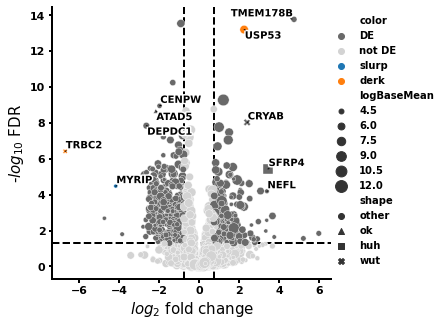

In [5]:
volcano(df, color_dict = {'derk' : ['USP53', 'TRBC2'], 'slurp': ['MYRIP']},
        shape_dict = {'wut' : ['CRYAB', 'TRBC2'], 'huh': ['SFRP4'], 'ok': ['ATAD5' ,'ACAP3']}, baseMean = 'mean',
       log2fc = 'change')

In [6]:
df

,Unnamed: 0,mean,change,lfcSE,stat,pvalue,padj,symbol
0,ENSG00000160072,320.481168,-0.492442,0.165330,-2.978533,0.002896,0.036899,ATAD3B
1,ENSG00000041988,103.354977,-0.282331,0.168099,-1.679553,0.093044,0.359646,THAP3
2,ENSG00000225630,922.811465,0.733032,0.375566,1.951807,0.050961,0.256948,MTND2P28
3,ENSG00000131584,735.890219,-0.053477,0.219621,-0.243496,0.807621,0.938042,ACAP3
4,ENSG00000169972,135.304763,-0.154869,0.187044,-0.827982,0.407681,0.727888,PUSL1
...,...,...,...,...,...,...,...,...
10926,ENSG00000198786,45775.084126,0.165326,0.206643,0.800055,0.423679,0.738798,ND5
10927,ENSG00000198695,10271.242782,0.184644,0.222985,0.828053,0.407640,0.727888,ND6
10928,ENSG00000198727,46929.471443,0.271033,0.258781,1.047347,0.294939,0.633176,CYTB
10929,ENSG00000210196,77.259551,0.454467,0.249443,1.821928,0.068466,0.304236,NaN


In [7]:
#volcano(df, symbol='Unnamed: 0', to_label = [])

In [8]:
df = pd.read_csv('test_1.csv')

In [9]:
df[df.log2FoldChange == 0]

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
17,ENSMUSG00000103067,21.060103,0.0,1.726583,0.0,1.0,1.0
49,ENSMUSG00000025930,0.103649,0.0,5.267649,0.0,1.0,NaN
59,ENSMUSG00000089982,0.097630,0.0,5.267649,0.0,1.0,NaN
65,ENSMUSG00000101640,0.438053,0.0,5.267649,0.0,1.0,NaN
107,ENSMUSG00000053185,0.110643,0.0,5.267649,0.0,1.0,NaN
...,...,...,...,...,...,...,...
26027,ENSMUSG00000094514,0.349083,0.0,5.267649,0.0,1.0,NaN
26028,ENSMUSG00000094915,9.945419,0.0,1.884657,0.0,1.0,1.0
26032,ENSMUSG00000094874,0.301394,0.0,5.267649,0.0,1.0,NaN
26044,ENSMUSG00000096730,0.338913,0.0,5.267649,0.0,1.0,NaN


In [10]:
df.pvalue.min()

0.0

In [11]:
volcano?

Signature:
volcano(
    data,
    log2fc='log2FoldChange',
    pvalue='padj',
    symbol='symbol',
    baseMean=None,
    pval_thresh=0.05,
    log2fc_thresh=0.75,
    to_label=5,
    color_dict=None,
    shape_dict=None,
    fontsize=10,
    colors=['dimgrey', 'lightgrey', 'black'],
    top_right_frame=False,
    figsize=(5, 5),
    legend_pos=(1.4, 1),
    point_sizes=(15, 150),
    save=False,
    shapes=None,
    shape_order=None,
)
Docstring:
Make a volcano plot from a pandas dataframe of directly from a csv.

data : pandas.DataFrame or path to csv
log2fc : string
    column name of log2 Fold-Change values
pvalue : string
    column name of the p values to be converted to -log10 P values
symbol : string
    column name of gene IDs to use
baseMean : string
    column name of base mean values for each gene. If this is passed, 
    the size of the points will vary.
pval_thresh : numeric
    threshold pvalue for points to be significant. Also controls horizontal
    line.
log2fc_thres

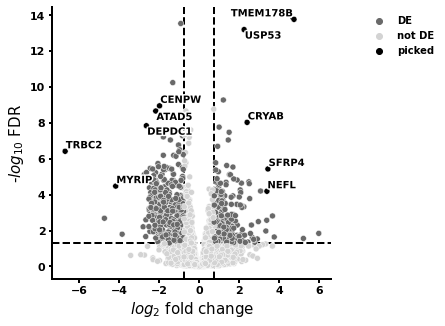

In [12]:
volcano('DE_results.csv')

In [13]:
#df[df.color == 'derk']

In [14]:
#df[df.color == 'DE']

In [15]:
df

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSMUSG00000051951,0.225419,1.849631,5.231347,0.353567,7.236635e-01,NaN
1,ENSMUSG00000025900,0.643533,1.666435,5.244344,0.317759,7.506681e-01,NaN
2,ENSMUSG00000104328,0.226772,2.758970,5.186206,0.531982,5.947383e-01,NaN
3,ENSMUSG00000033845,6852.910721,-0.296630,0.058230,-5.094139,3.503289e-07,9.886845e-07
4,ENSMUSG00000025903,5708.829383,-0.423870,0.064547,-6.566882,5.137984e-11,1.854261e-10
...,...,...,...,...,...,...,...
26057,ENSMUSG00000095763,1.593120,4.611301,2.644127,1.743979,8.116279e-02,1.227928e-01
26058,ENSMUSG00000095475,2.452819,3.042446,2.032181,1.497134,1.343585e-01,1.915004e-01
26059,ENSMUSG00000094855,0.584201,3.063962,3.458998,0.885795,3.757282e-01,NaN
26060,ENSMUSG00000095041,13460.520000,-0.530637,0.094171,-5.634838,1.752234e-08,5.425242e-08


# GSEA analysis in Python by using gseapy

In [16]:
import pandas as pd
from gseapy.plot import gseaplot
import gseapy as gp
import numpy as np
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('DE_results.csv').dropna()
df = df.rename(columns = {'symbol': 'Gene'})
#df = df[df.padj < 0.05] it is best practice not to filter

df

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene
0,ENSG00000160072,320.481168,-0.492442,0.165330,-2.978533,0.002896,0.036899,ATAD3B
1,ENSG00000041988,103.354977,-0.282331,0.168099,-1.679553,0.093044,0.359646,THAP3
2,ENSG00000225630,922.811465,0.733032,0.375566,1.951807,0.050961,0.256948,MTND2P28
3,ENSG00000131584,735.890219,-0.053477,0.219621,-0.243496,0.807621,0.938042,ACAP3
4,ENSG00000169972,135.304763,-0.154869,0.187044,-0.827982,0.407681,0.727888,PUSL1
...,...,...,...,...,...,...,...,...
10925,ENSG00000198886,97413.360359,0.131197,0.238091,0.551037,0.581608,0.836573,ND4
10926,ENSG00000198786,45775.084126,0.165326,0.206643,0.800055,0.423679,0.738798,ND5
10927,ENSG00000198695,10271.242782,0.184644,0.222985,0.828053,0.407640,0.727888,ND6
10928,ENSG00000198727,46929.471443,0.271033,0.258781,1.047347,0.294939,0.633176,CYTB


In [18]:
df['Rank'] = -np.log10(df.padj)*df.log2FoldChange

df = df.sort_values('Rank', ascending = False).reset_index(drop = True)

df

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene,Rank
0,ENSG00000261115,193.721808,4.741075,0.537213,8.825318,1.091489e-18,1.672817e-14,TMEM178B,65.315669
1,ENSG00000145390,2016.886474,2.249586,0.263078,8.551018,1.220076e-17,6.232962e-14,USP53,29.706469
2,ENSG00000109846,524.720804,2.398381,0.348668,6.878701,6.040066e-12,9.257006e-09,CRYAB,19.267466
3,ENSG00000106483,7321.978396,3.438204,0.602508,5.706491,1.153292e-08,3.668965e-06,SFRP4,18.688209
4,ENSG00000277586,78.098744,3.388113,0.677038,5.004316,5.606066e-07,6.411834e-05,NEFL,14.206417
...,...,...,...,...,...,...,...,...,...
10808,ENSG00000203760,107.203668,-1.974640,0.272572,-7.244486,4.340832e-13,1.108793e-09,CENPW,-17.683201
10809,ENSG00000170011,53.464280,-4.163618,0.803520,-5.181720,2.198487e-07,3.311684e-05,MYRIP,-18.652804
10810,ENSG00000176208,75.279706,-2.164796,0.304987,-7.097984,1.265898e-12,2.155684e-09,ATAD5,-18.761020
10811,ENSG00000024526,341.005688,-2.632820,0.386997,-6.803209,1.023138e-11,1.425510e-08,DEPDC1,-20.657185


In [19]:
ranking = df[['Gene', 'Rank']]
ranking

,Gene,Rank
0,TMEM178B,65.315669
1,USP53,29.706469
2,CRYAB,19.267466
3,SFRP4,18.688209
4,NEFL,14.206417
...,...,...
10808,CENPW,-17.683201
10809,MYRIP,-18.652804
10810,ATAD5,-18.761020
10811,DEPDC1,-20.657185


In [20]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbations_GEO_2022',
 'DisGeNET',
 'Disease_

In [22]:
## gp.prerank creating an issue if I am running in contnious.
# If I am running whole code it's getting error here. If I am running manually this part then it's working.
# If I will use 10 second gap, it will work. https://stackoverflow.com/questions/64018551/permissionerror-when-directories-are-opened
#import time
#time.sleep(15)
pre_res = gp.prerank(rnk = ranking, gene_sets = 'GO_Biological_Process_2021', seed = 6, permutation_num = 100)

In [23]:
out = []

for term in list(pre_res.results):
    out.append([term,
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes']])

out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop = True)
out_df

,Term,fdr,es,nes
0,mitotic chromosome condensation (GO:0007076),0.0,-0.947501,-1.686037
1,microtubule cytoskeleton organization involved...,0.0,-0.908678,-1.788175
2,regulation of mitotic cell cycle phase transit...,0.0,-0.865540,-1.736827
3,double-strand break repair via homologous reco...,0.0,-0.898867,-1.703369
4,mitotic nuclear division (GO:0140014),0.0,-0.908804,-1.722231
...,...,...,...,...
2017,regulation of androgen receptor signaling path...,1.0,0.275919,0.523636
2018,positive regulation of DNA-templated transcrip...,1.0,-0.438647,-0.688153
2019,positive regulation of JNK cascade (GO:0046330),1.0,-0.398965,-0.675827
2020,"nucleotide-binding domain, leucine rich repeat...",1.0,0.243430,0.428615


In [24]:
term_to_graph = out_df.iloc[0].Term
term_to_graph

'mitotic chromosome condensation (GO:0007076)'

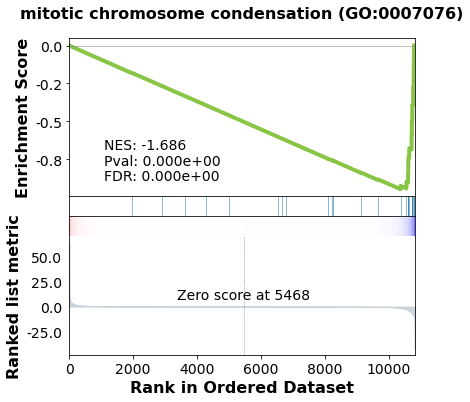

In [25]:
gseaplot(pre_res.ranking, term = term_to_graph, **pre_res.results[term_to_graph])
#gseaplot(pre_res.ranking, term = term_to_graph, **pre_res.results[term_to_graph], ofname='GO 0034645.pdf') # tosave the plot in pdf

# MSigDB enrichment analysis and plot

In [26]:
pre_res = gp.prerank(rnk = ranking, gene_sets = 'MSigDB_Hallmark_2020', seed = 6, permutation_num = 100)


out = []

for term in list(pre_res.results):
    out.append([term,
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes']])

out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop = True)
out_df = out_df[out_df['fdr'] < 0.01] ## Select Hallmark pathways with FDR below 0.01
out_df

,Term,fdr,es,nes
0,Mitotic Spindle,0.000000,-0.851995,-1.758283
1,Hypoxia,0.000000,0.819362,1.820759
2,Myc Targets V1,0.000000,-0.862060,-1.813798
3,Coagulation,0.000000,0.838962,1.826999
4,E2F Targets,0.000000,-0.925743,-1.879839
5,G2-M Checkpoint,0.000000,-0.923725,-1.900617
6,DNA Repair,0.004781,-0.767959,-1.548056
7,Spermatogenesis,0.008878,-0.829806,-1.489578
8,Myc Targets V2,0.009561,-0.815931,-1.494900


In [27]:
term_to_graph = out_df.iloc[0].Term
term_to_graph

'Mitotic Spindle'

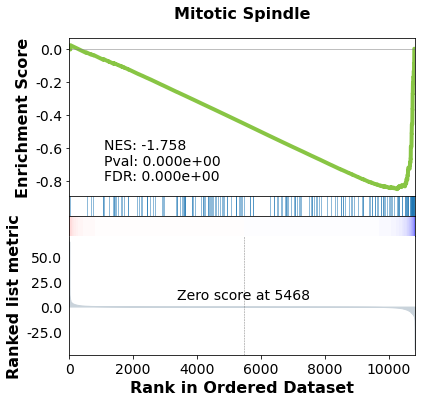

In [28]:
# display and save pathway in pdf format
gseaplot(pre_res.ranking, term = term_to_graph, **pre_res.results[term_to_graph], cmap=plt.cm.seismic)
gseaplot(pre_res.ranking, term = term_to_graph, **pre_res.results[term_to_graph], ofname='E2F Targets.pdf') # tosave the plot in pdf

In [29]:
?gseaplot

Signature:
gseaplot(
    rank_metric: Iterable,
    term: str,
    hits: List[int],
    nes: float,
    pval: float,
    fdr: float,
    RES: float,
    pheno_pos: str = '',
    pheno_neg: str = '',
    figsize: Tuple[float] = (6, 5.5),
    cmap: str = 'seismic',
    ofname: Union[str, NoneType] = None,
    **kwargs,
)
Docstring:
This is the main function for reproducing the gsea plot.

:param rank_metric: pd.Series for rankings, rank_metric.values.
:param term: gene_set name
:param hits: hits indices of rank_metric.index presented in gene set S.
:param nes: Normalized enrichment scores.
:param pval: nominal p-value.
:param fdr: false discovery rate.
:param RES: running enrichment scores.
:param pheno_pos: phenotype label, positive correlated.
:param pheno_neg: phenotype label, negative correlated.
:param figsize: matplotlib figsize.
:param ofname: output file name. If None, don't save figure
File:      c:\users\nmishra\anaconda3\lib\site-packages\gseapy\plot.py
Type:      function
